In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/Users/EllaPrice/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [13]:
df = pd.read_csv('final_1001_unscaled.csv')

In [14]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.set_index('date', inplace=True)


In [15]:
df

,T2M_RANGE,T2M_MAX,PRECTOT,WS10M_MIN,WS50M,PS,WS50M_RANGE,WS50M_MAX,WS10M_RANGE,score
date,,,,,,,,,,
2000-01-04,15.92,18.09,15.95,2.08,6.73,100.29,5.58,9.31,3.59,1.000000
2000-01-05,13.48,10.82,0.00,0.52,2.94,101.15,4.19,4.85,1.98,1.142857
2000-01-06,15.85,12.89,0.01,0.04,2.95,101.31,5.17,5.22,2.35,1.285714
2000-01-07,13.88,14.51,0.01,1.59,5.02,101.37,4.03,6.47,1.69,1.428571
2000-01-08,13.04,15.78,1.02,1.50,4.17,100.77,3.72,5.73,1.40,1.571429
...,...,...,...,...,...,...,...,...,...,...
2020-12-27,16.42,13.08,0.00,0.88,4.34,100.73,5.49,6.67,1.76,0.000000
2020-12-28,14.70,15.35,0.05,0.76,3.21,101.07,3.59,5.00,1.16,0.000000
2020-12-29,11.78,17.56,0.11,1.60,4.32,101.10,3.81,6.55,0.73,0.000000


In [16]:
# Train test split
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

6901 767


In [17]:
from sklearn.preprocessing import RobustScaler

f_columns = ['T2M_RANGE','T2M_MAX', 'PRECTOT', 'WS10M_MIN', 'WS50M', 'PS','WS50M_RANGE', 'WS50M_MAX', 'WS10M_RANGE']

f_transformer = RobustScaler()
score_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
score_transformer = score_transformer.fit(train[['score']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['score'] = score_transformer.transform(train[['score']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['score'] = score_transformer.transform(test[['score']])

/Users/EllaPrice/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-17-cf851ba79025>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
<ipython-input-17-cf851ba79025>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [18]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [19]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.score, time_steps)
X_test, y_test = create_dataset(test, test.score, time_steps)

print(X_train.shape, y_train.shape)

(6891, 10, 10) (6891,)


In [20]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
194/194 [==============================] - 11s 31ms/step - loss: 0.2651 - val_loss: 0.0141
Epoch 2/30
194/194 [==============================] - 6s 34ms/step - loss: 0.0290 - val_loss: 0.0107
Epoch 3/30
194/194 [==============================] - 5s 23ms/step - loss: 0.0272 - val_loss: 0.0090
Epoch 4/30
194/194 [==============================] - 7s 38ms/step - loss: 0.0200 - val_loss: 0.0077
Epoch 5/30
194/194 [==============================] - 5s 28ms/step - loss: 0.0218 - val_loss: 0.0103
Epoch 6/30
194/194 [==============================] - 7s 35ms/step - loss: 0.0405 - val_loss: 0.0105
Epoch 7/30
194/194 [==============================] - 7s 37ms/step - loss: 0.0496 - val_loss: 0.0072
Epoch 8/30
194/194 [==============================] - 6s 32ms/step - loss: 0.0156 - val_loss: 0.0053
Epoch 9/30
194/194 [==============================] - 8s 41ms/step - loss: 0.0121 - val_loss: 0.0042
Epoch 10/30
194/194 [==============================] - 5s 26ms/step - loss: 0.0103 - val_l

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               142336    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 142,593
Trainable params: 142,593
Non-trainable params: 0
_________________________________________________________________


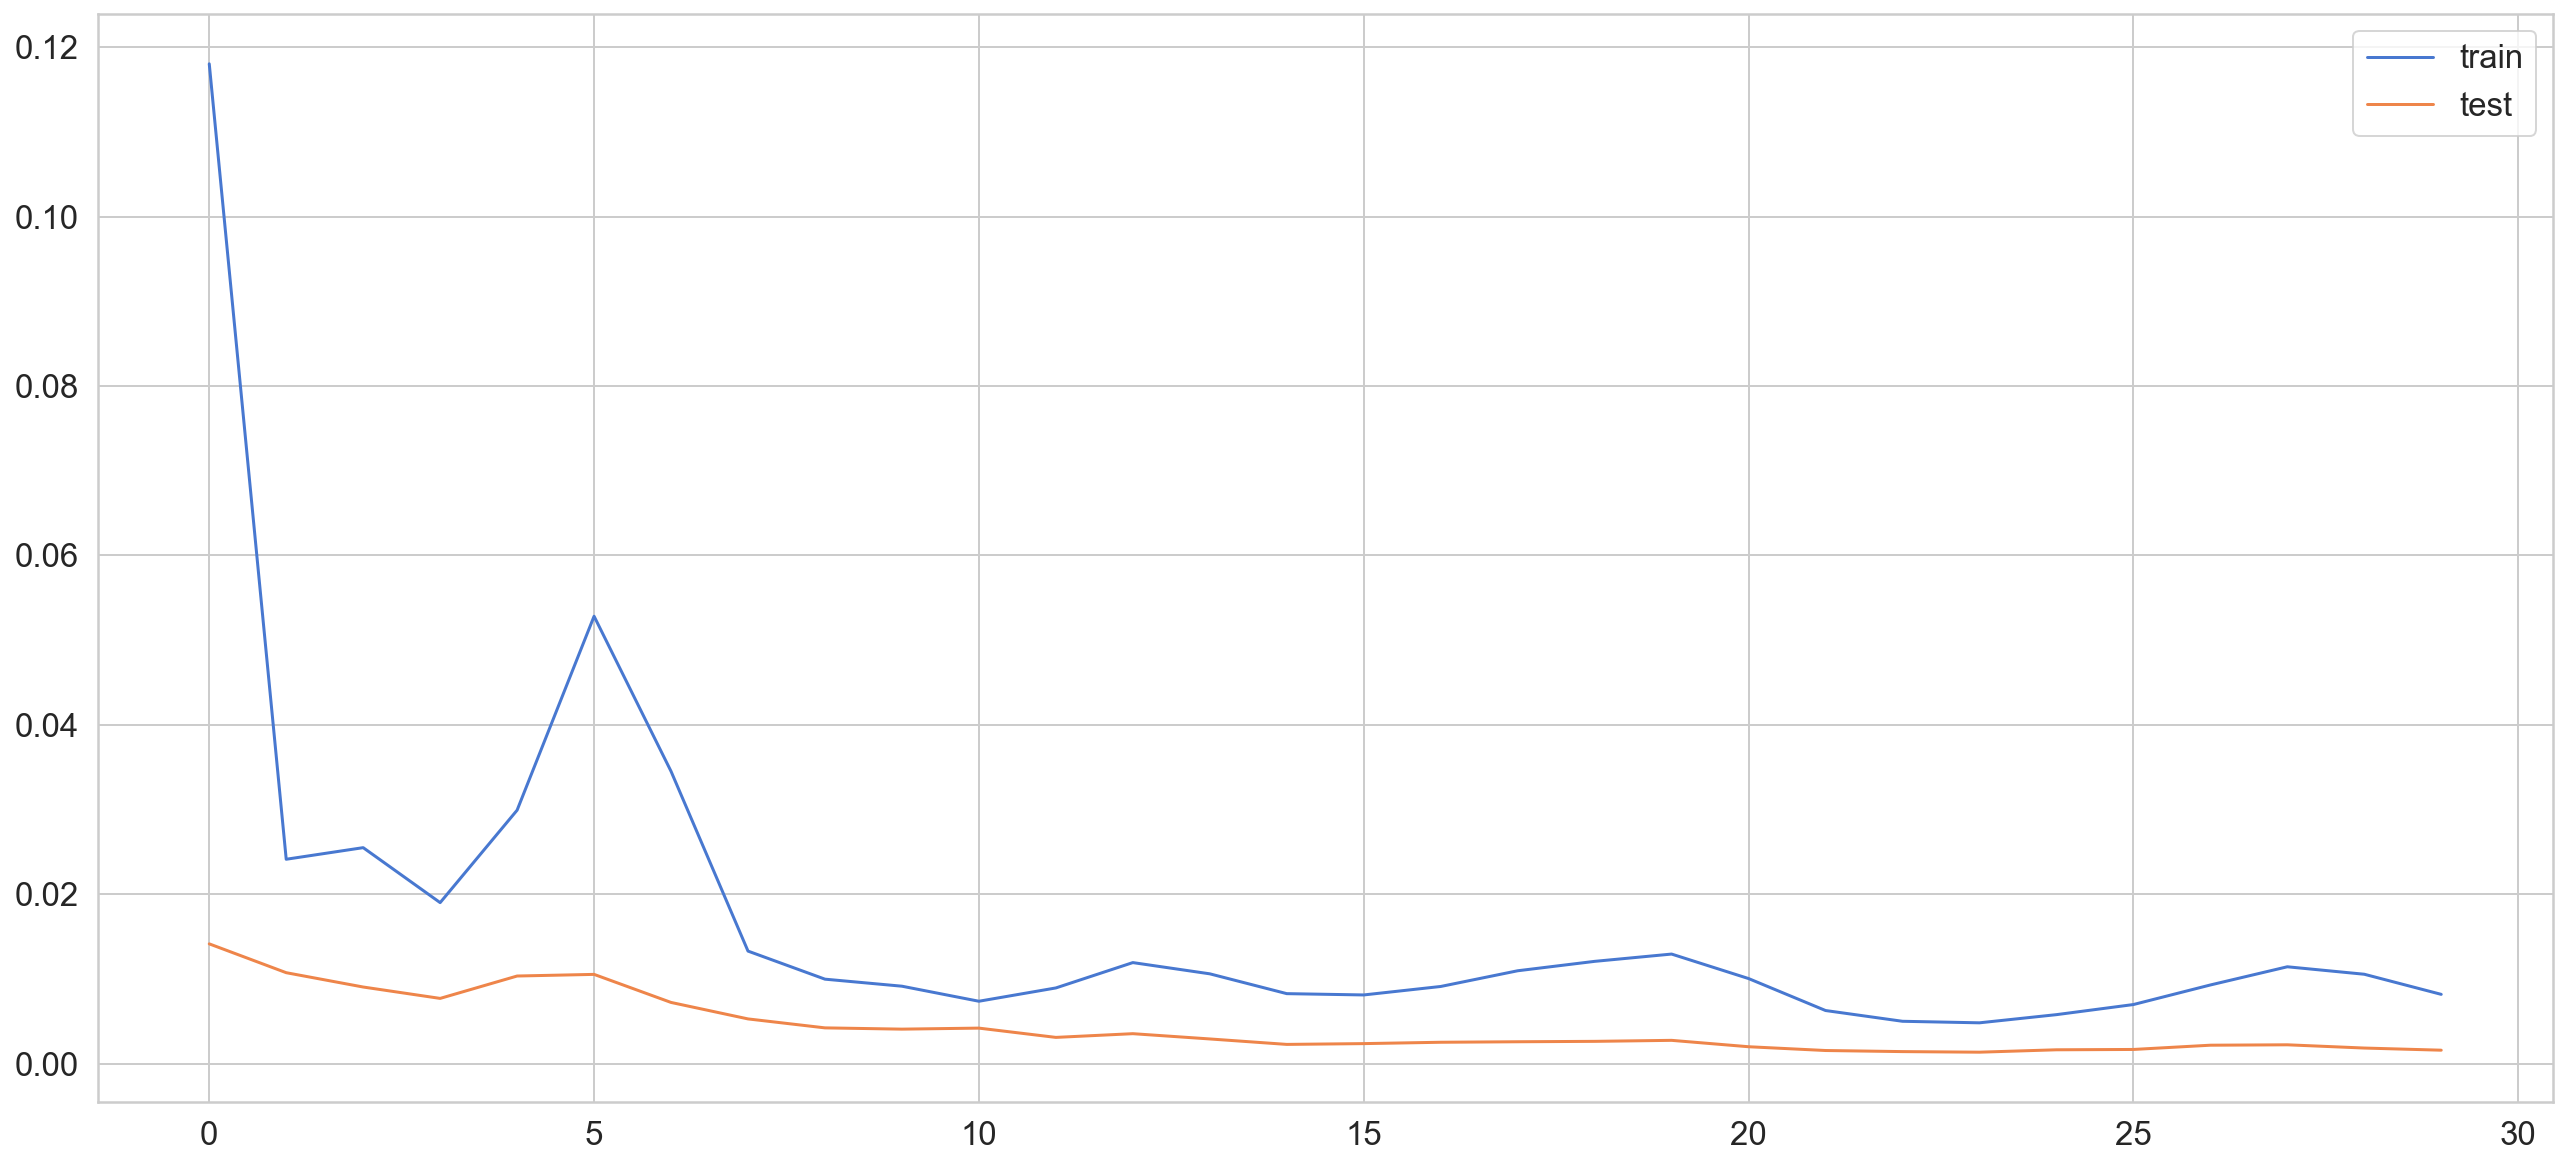

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [24]:
y_pred = model.predict(X_test)

In [25]:
y_train_inv = score_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = score_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = score_transformer.inverse_transform(y_pred)

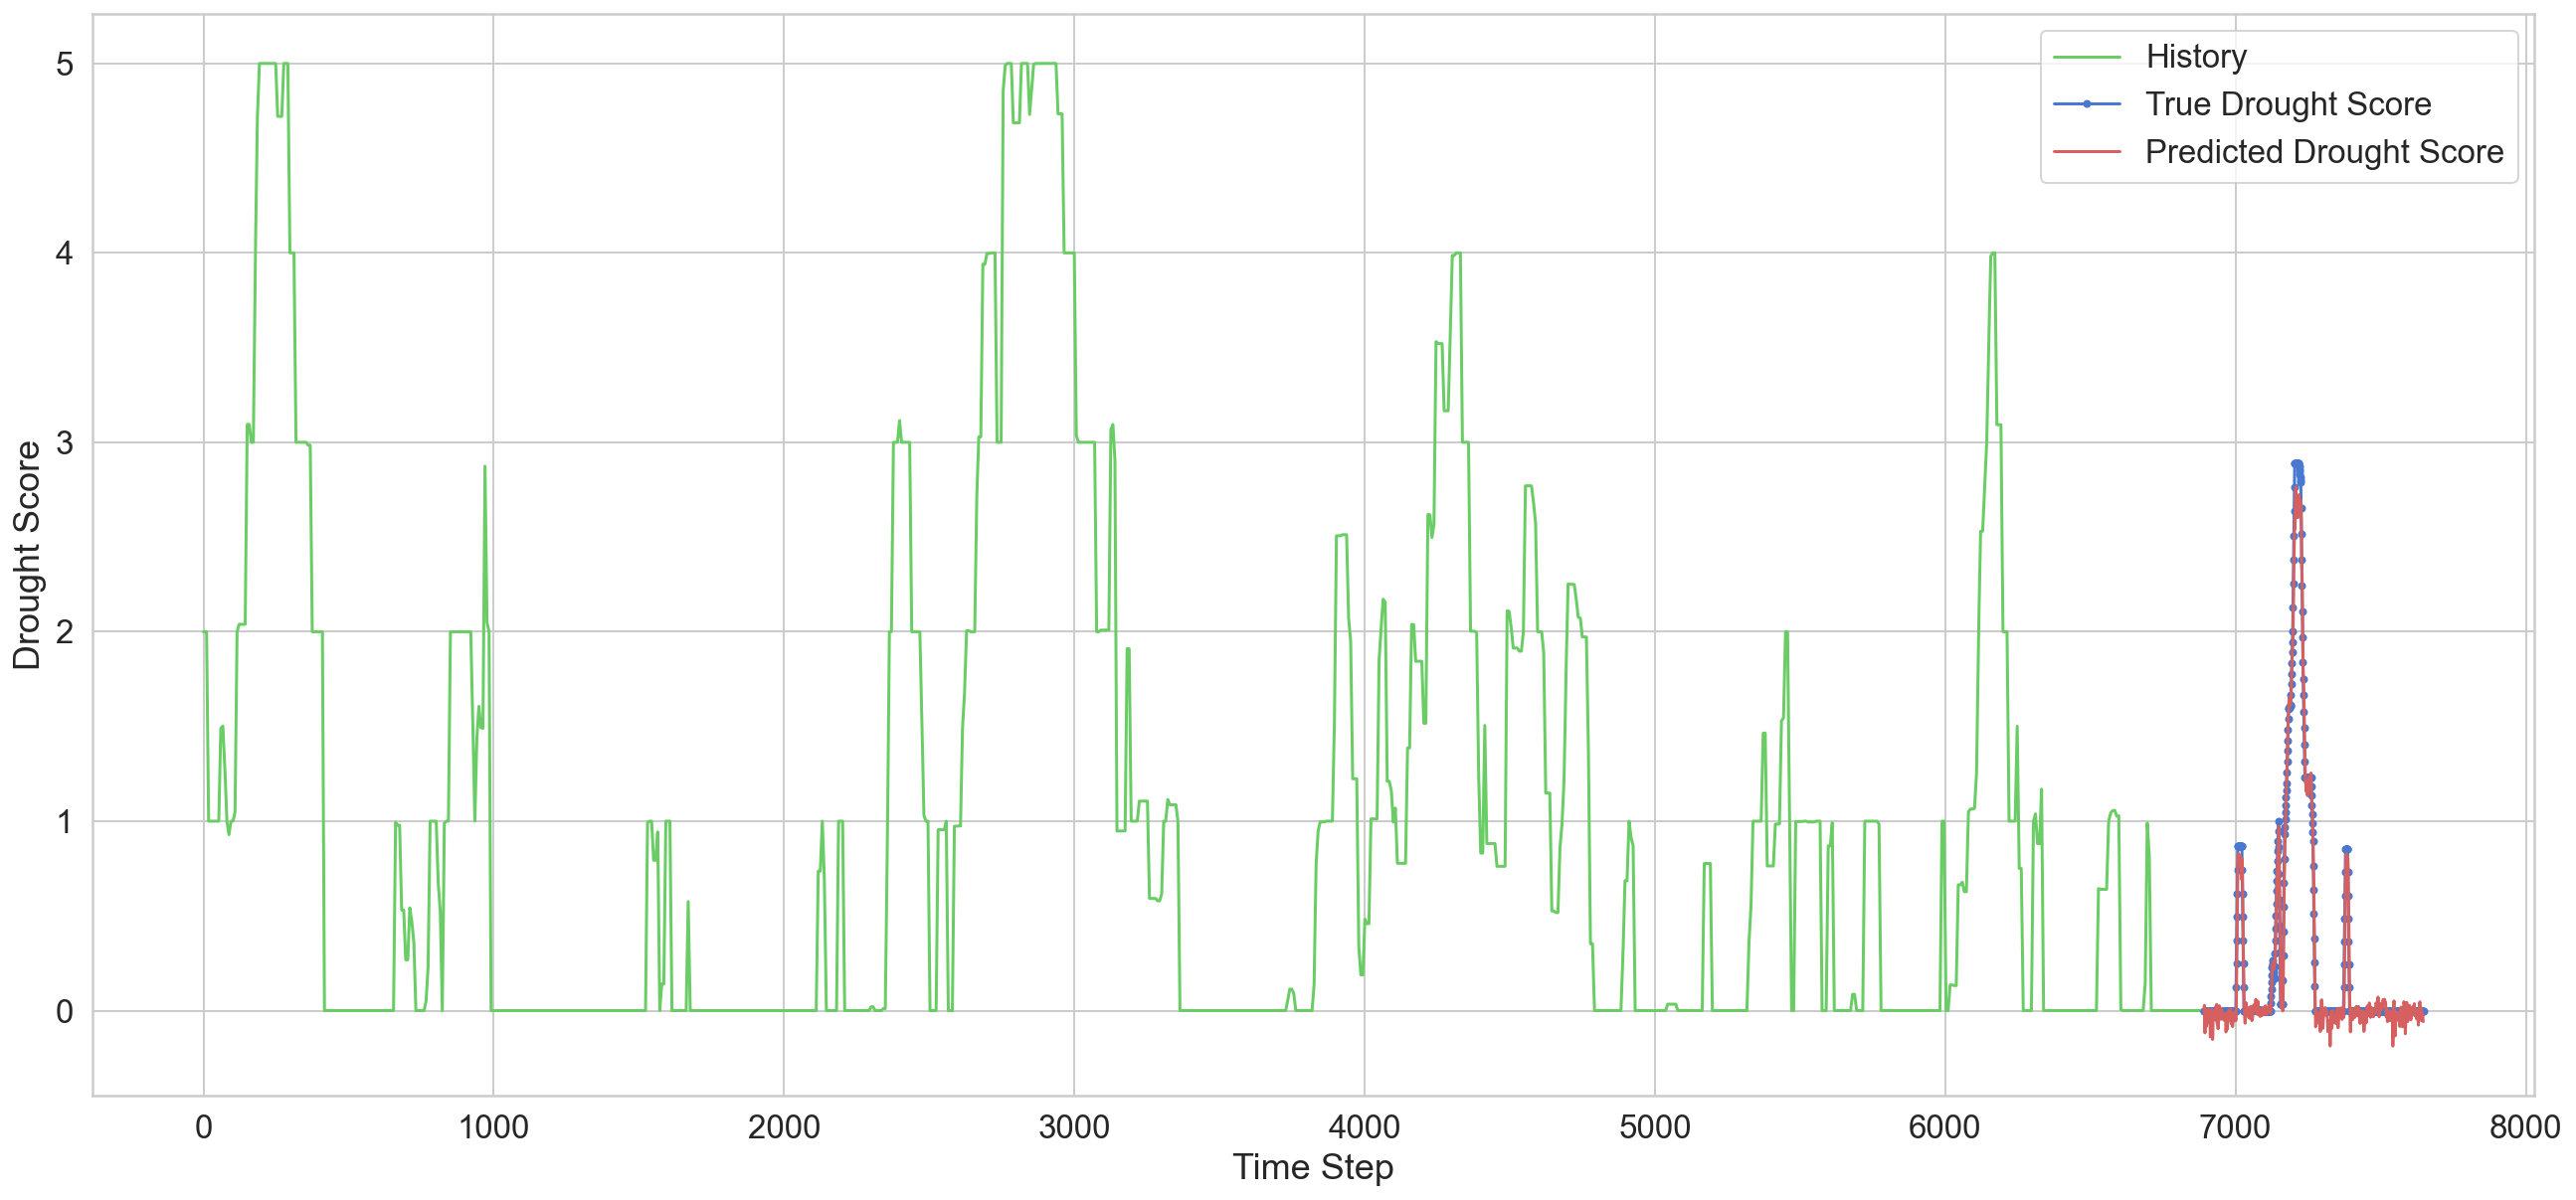

In [26]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="True Drought Score")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="Predicted Drought Score")
plt.ylabel('Drought Score')
plt.xlabel('Time Step')
plt.legend()
plt.show();

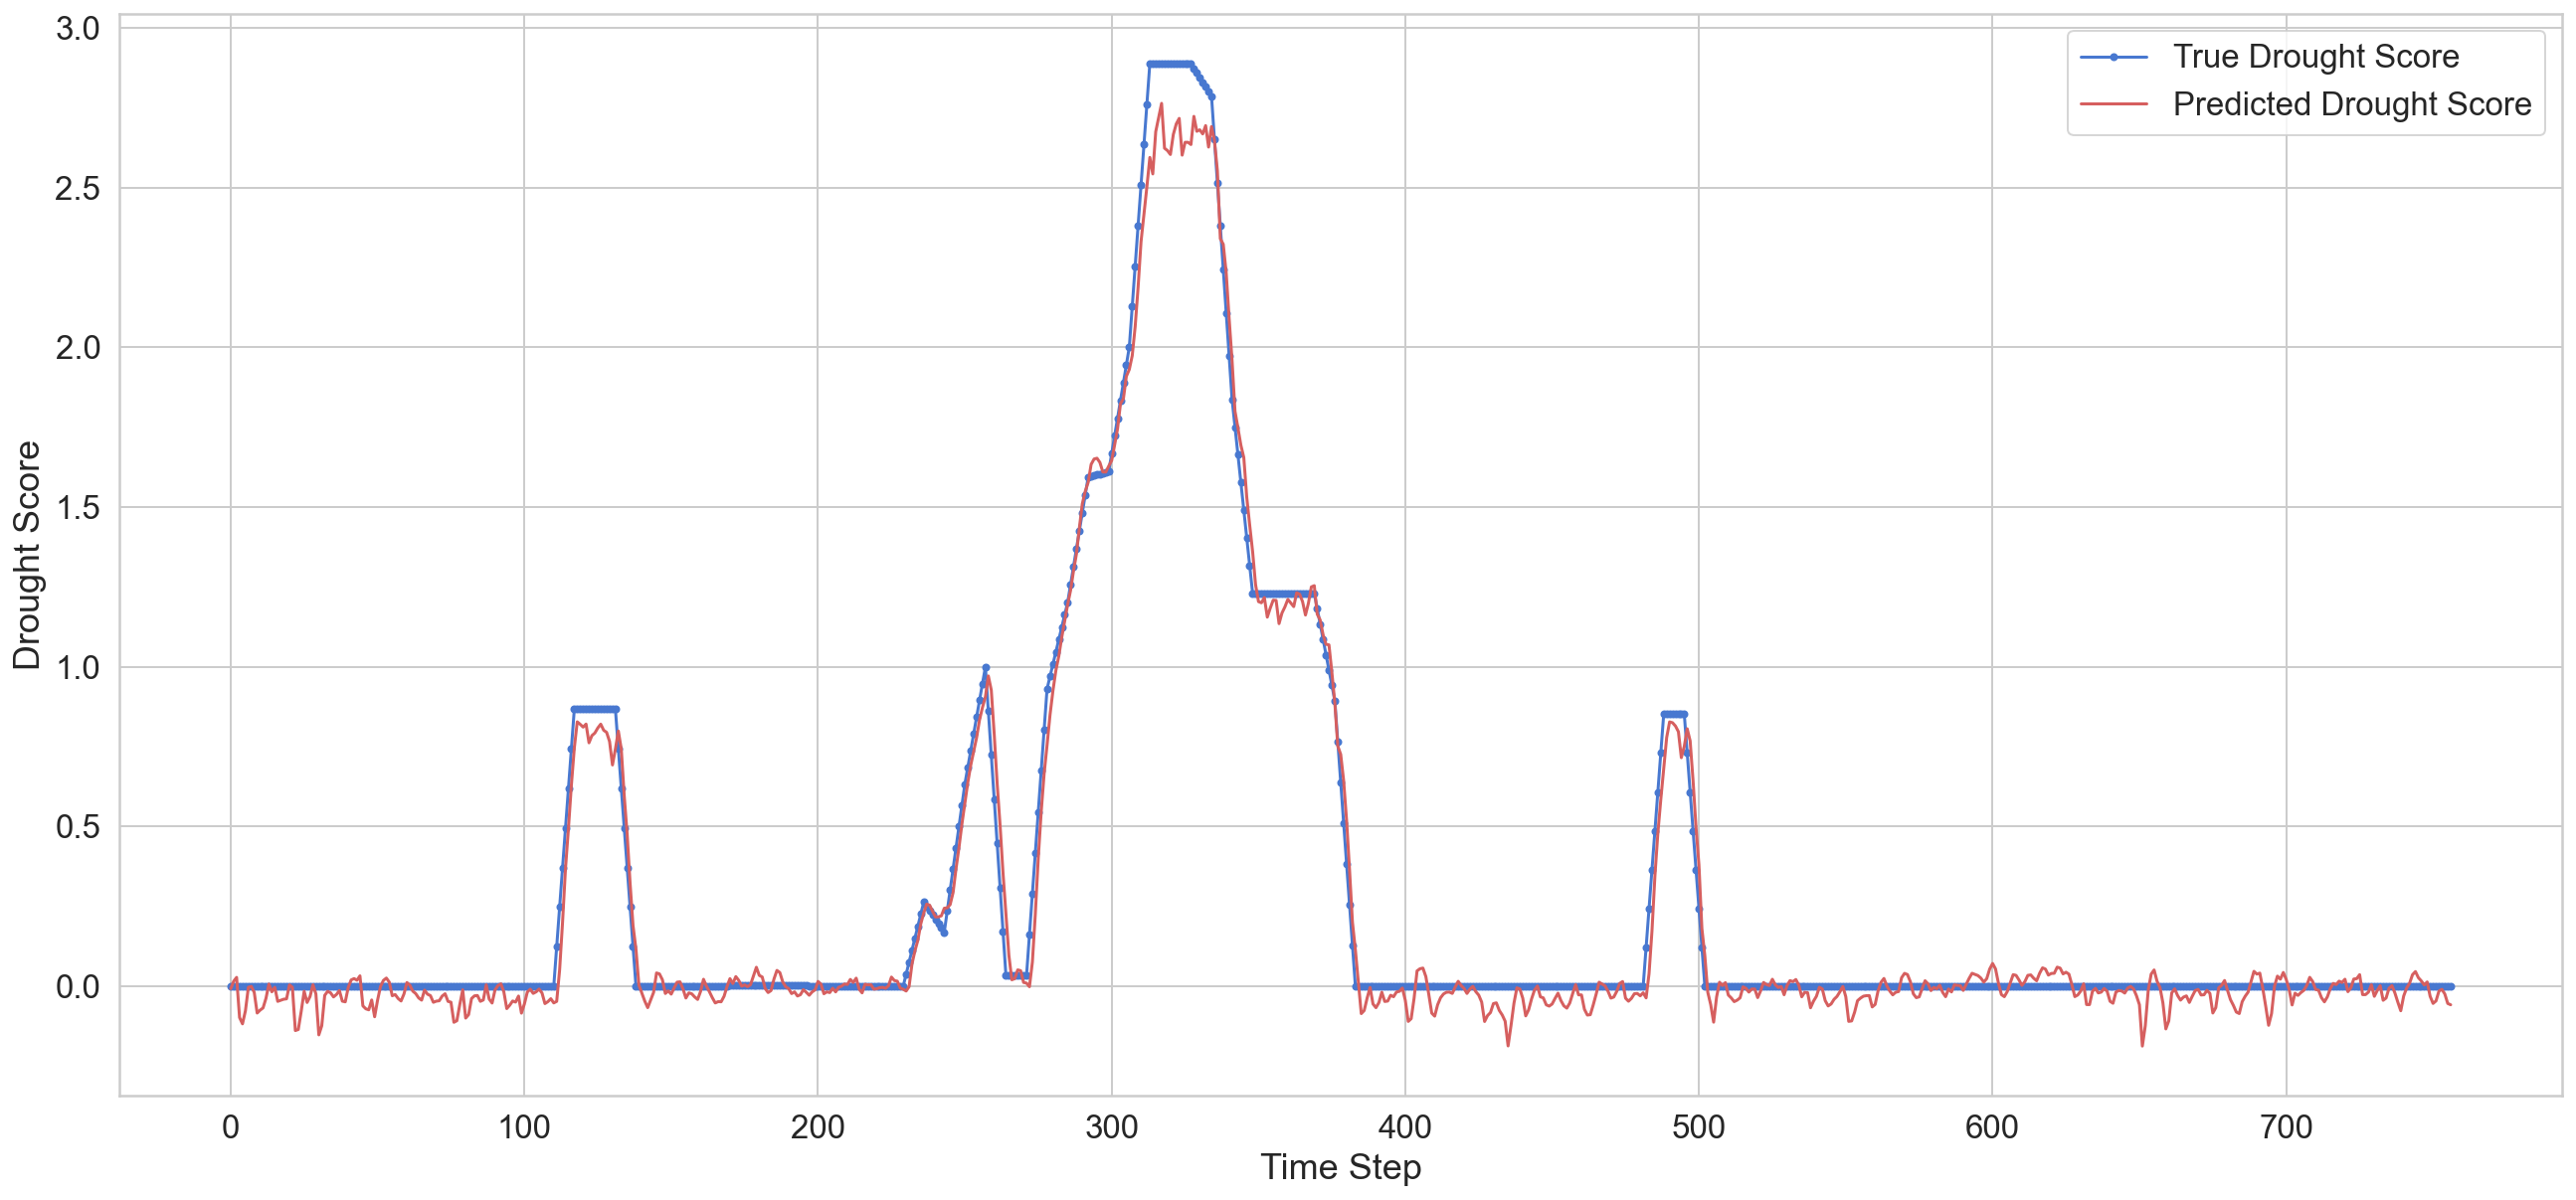

In [27]:
plt.plot(y_test_inv.flatten(), marker='.', label="True Drought Score")
plt.plot(y_pred_inv.flatten(), 'r', label="Predicted Drought Score")
plt.ylabel('Drought Score')
plt.xlabel('Time Step')
plt.legend()
plt.show();